In [23]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain

In [24]:
# 加载数据
authors = pd.read_csv(r'C:\Users\Chen Ray\Skills-Assessment-2\outputs\authors_cleaned.csv')

In [25]:
# 构建合作网络
G = nx.Graph()

In [26]:
# 添加节点和边
for pmid, group in authors.groupby('PMID'):
    authors_list = group['AuthorFullName'].tolist()
    for i in range(len(authors_list)):
        for j in range(i + 1, len(authors_list)):
            G.add_edge(authors_list[i], authors_list[j])

In [27]:
# 计算度中心性
degree_centrality = nx.degree_centrality(G)

# 计算介数中心性（使用近似算法）
betweenness_centrality = nx.betweenness_centrality(G, k=100, seed=42)  # k为样本节点数

# 计算特征向量中心性（使用迭代次数较少的近似算法）
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=100)

In [28]:

# 打印前10个关键研究者
print("Top 10 Researchers by Degree Centrality:")
print(sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10])

print("Top 10 Researchers by Betweenness Centrality:")
print(sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10])

print("Top 10 Researchers by Eigenvector Centrality:")
print(sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:10])


Top 10 Researchers by Degree Centrality:
[('John Hardy', 0.03471966629861367), ('Henrik Zetterberg', 0.033738191632928474), ('Jonathan L Haines', 0.0326647037173353), ('Cornelia M van Duijn', 0.032081953134584715), ('Margaret A Pericak-Vance', 0.03195926880137406), ('Kaj Blennow', 0.031161820635504846), ('Magda Tsolaki', 0.030701754385964914), ('Gerard D Schellenberg', 0.03064041221935959), ('Lindsay A Farrer', 0.03011900380321433), ('Hilkka Soininen', 0.02929088455404245)]
Top 10 Researchers by Betweenness Centrality:
[('Magda Tsolaki', 0.15163170150006847), ('John Hardy', 0.03402161742785784), ('R Mayeux', 0.029309877556254558), ('Patrick M Sullivan', 0.01776732625064255), ('Carlos Cruchaga', 0.0169912502098919), ('Andrew J Saykin', 0.016346222045129644), ('John C Morris', 0.016022107664692593), ('D Rabinowitz', 0.015262208389608511), ('Kwangsik Nho', 0.014028791378974682), ('Richard Mayeux', 0.0138399842046582)]
Top 10 Researchers by Eigenvector Centrality:
[('Hilkka Soininen', 0.05

In [29]:
# 社区检测（使用Louvain算法）
partition = community_louvain.best_partition(G)

In [30]:
# 将节点按社区分组
communities = {}
for node, community in partition.items():
    if community not in communities:
        communities[community] = []
    communities[community].append(node)

In [31]:
# 打印前5个社区
print("Top 5 Communities:")
for i, (community, members) in enumerate(communities.items()):
    if i >= 5:
        break
    print(f"Community {i + 1}: {members}")

Top 5 Communities:
Community 1: ['K E Morrison', 'G Steers', 'V Dubowitz']
Community 2: ['M L Brandi', 'L Becherini', 'L Gennari', 'M Racchi', 'A Bianchetti', 'B Nacmias', 'S Sorbi', 'P Mecocci', 'U Senin', 'S Govoni', 'C Geroldi', 'M Pihlajamäki', 'M P Laakso', 'C DeCarli', 'A Beltramello', 'H Soininen', 'M Trabucchi', 'G B Frisoni', 'V Alvarez', 'R Alvarez', 'J Peña', 'C H Lahoz', 'C Martínez', 'L Menéndez-Guisasola', 'J Salas-Puig', 'G Morís', 'D Uría', 'B B Menes', 'R Ribacoba', 'J A Vidal', 'E Coto', 'J M Johnston', 'M Ganguli', 'J C Lambert', 'T Brousseau', 'V Defosse', 'A Evans', 'D Arveiler', 'J B Ruidavets', 'B Haas', 'J P Cambou', 'G Luc', 'P Ducimetière', 'F Cambien', 'M C Chartier-Harlin', 'P Amouyel', 'R M Corbo', 'R Scacchi', 'L Mureddu', 'G Mulas', 'S Castrechini', 'A P Rivasi', 'J Chapman', 'C Sylantiev', 'P Nisipeanu', 'A D Korczyn', 'D Tsuang', 'E B Larson', 'J Bowen', 'W McCormick', 'L Teri', 'D Nochlin', 'J B Leverenz', 'E R Peskind', 'A Lim', 'M A Raskind', 'M L Th

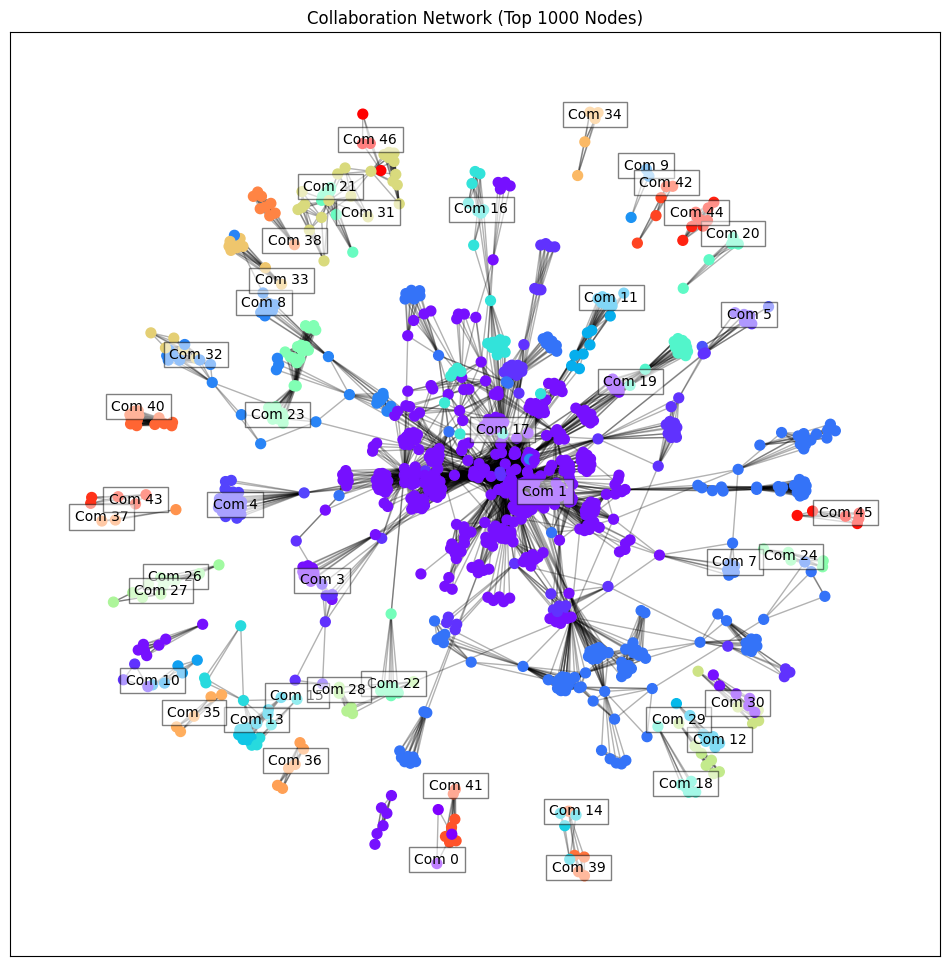

In [41]:
# 只可视化前1000个节点和边
subgraph_nodes = list(G.nodes)[:1000]
subgraph = G.subgraph(subgraph_nodes)

# 可视化合作网络
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(subgraph, k=0.1)
nx.draw_networkx_nodes(subgraph, pos, node_size=50, node_color=[partition[node] for node in subgraph.nodes()], cmap=plt.cm.rainbow)
nx.draw_networkx_edges(subgraph, pos, alpha=0.3)

# 标注社区名
for community_id, members in communities.items():
    if any(node in subgraph_nodes for node in members):
        x, y = pos[members[0]]
        plt.text(x, y, f'Com {community_id}', bbox=dict(facecolor='white', alpha=0.5), horizontalalignment='center')

plt.title('Collaboration Network (Top 1000 Nodes)')
plt.savefig(r'C:\Users\Chen Ray\Skills-Assessment-2\outputs\collaboration_network.png')
plt.show()